In [1]:
# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load dataset
df = pd.read_csv('bitcoin_data.csv')

In [3]:
# Extract year, month, and day from 'Date'
splitted = df['Date'].str.split('-', expand=True)
df['year'] = splitted[0].astype('int')
df['month'] = splitted[1].astype('int')
df['day'] = splitted[2].astype('int')

# Convert the 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
# Add quarter-end indicator
df['is_quarter_end'] = np.where(df['month'] % 3 == 0, 1, 0)


In [5]:
# Feature engineering
df['open-close'] = df['Open'] - df['Close']
df['low-high'] = df['Low'] - df['High']
df['target'] = df['Close'].shift(-1)  # Predict the next close price
df['ma7'] = df['Close'].rolling(window=7).mean()
df['ma30'] = df['Close'].rolling(window=30).mean()
df['daily_return'] = df['Close'].pct_change()
df['volatility'] = df['Close'].rolling(window=7).std()

# Drop rows with NaN values caused by rolling calculations
df = df.dropna()

In [6]:
# Define features and target
features = df[['open-close', 'low-high', 'is_quarter_end', 'ma7', 'ma30', 'daily_return', 'volatility']].values
target = df['target'].values

# Normalize features
def normalize(data):
    std_dev = data.std(axis=0)
    # Avoid division by zero by replacing zero std with 1
    std_dev[std_dev == 0] = 1
    return (data - data.mean(axis=0)) / std_dev

features = normalize(features)

# Split dataset into training and validation sets
split_index = int(len(features) * 0.9)
X_train, X_valid = features[:split_index], features[split_index:]
Y_train, Y_valid = target[:split_index], target[split_index:]

In [7]:
import pickle
# Implement Linear Regression using numpy
class LinearRegression:
    def __init__(self):  # Fix constructor name
        self.weights = None

    def fit(self, X, y):
        X_b = np.hstack([np.ones((X.shape[0], 1)), X])  # Add bias term
        self.weights = np.linalg.pinv(X_b.T @ X_b) @ X_b.T @ y

    def predict(self, X):
        X_b = np.hstack([np.ones((X.shape[0], 1)), X])  # Add bias term
        return X_b @ self.weights

    def save(self, filename):
        """Save the model weights to a file."""
        with open(filename, 'wb') as file:
            pickle.dump(self.weights, file)
        print(f"Model weights saved to {filename}")

    def load(self, filename):
        """Load the model weights from a file."""
        with open(filename, 'rb') as file:
            self.weights = pickle.load(file)
        print(f"Model weights loaded from {filename}")


In [8]:
# Train and evaluate the models
lr_model = LinearRegression()
lr_model.fit(X_train, Y_train)

# Make predictions
train_pred = lr_model.predict(X_train)
valid_pred = lr_model.predict(X_valid)

# Evaluate the model
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

print('Linear Regression:')
print('Training MAE:', mean_absolute_error(Y_train, train_pred))
print('Validation MAE:', mean_absolute_error(Y_valid, valid_pred))
print('Validation RMSE:', root_mean_squared_error(Y_valid, valid_pred))

Linear Regression:
Training MAE: 563.2998867271209
Validation MAE: 1868.6981070571996
Validation RMSE: 2545.6974753117343


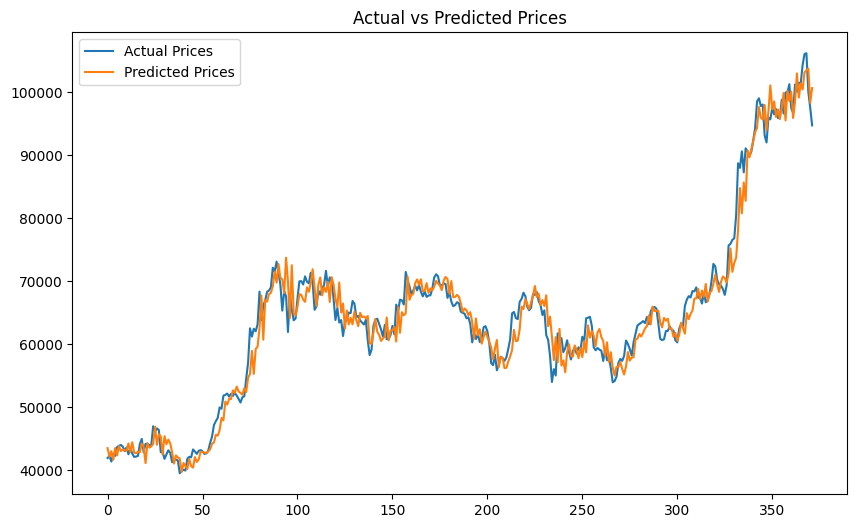

In [9]:
# Visualize predictions
plt.figure(figsize=(10, 6))
plt.plot(range(len(Y_valid)), Y_valid, label='Actual Prices')
plt.plot(range(len(Y_valid)), valid_pred, label='Predicted Prices')
plt.legend()
plt.title('Actual vs Predicted Prices')
plt.show()

Evaluation metrics

In [10]:
# %%
# Additional evaluation metrics
def r_squared(y_true, y_pred):
    """Calculate R-squared (coefficient of determination)."""
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

# Calculate metrics for training and validation
train_mae = mean_absolute_error(Y_train, train_pred)
valid_mae = mean_absolute_error(Y_valid, valid_pred)

train_rmse = root_mean_squared_error(Y_train, train_pred)
valid_rmse = root_mean_squared_error(Y_valid, valid_pred)

train_r2 = r_squared(Y_train, train_pred)
valid_r2 = r_squared(Y_valid, valid_pred)

# Display evaluation metrics
print('Linear Regression Metrics:')
print(f'Training MAE: {train_mae:.4f}, Validation MAE: {valid_mae:.4f}')
print(f'Training RMSE: {train_rmse:.4f}, Validation RMSE: {valid_rmse:.4f}')
print(f'Training R2: {train_r2:.4f}, Validation R2: {valid_r2:.4f}')


Linear Regression Metrics:
Training MAE: 563.2999, Validation MAE: 1868.6981
Training RMSE: 1125.4728, Validation RMSE: 2545.6975
Training R2: 0.9951, Validation R2: 0.9685


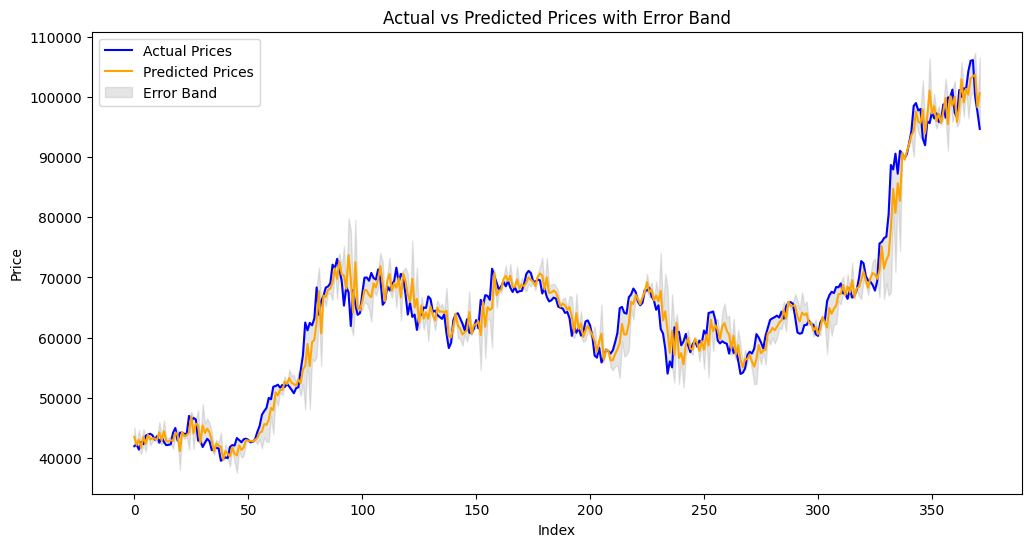

In [11]:
# %%
# Visualize predictions with errors
plt.figure(figsize=(12, 6))
plt.plot(range(len(Y_valid)), Y_valid, label='Actual Prices', color='blue')
plt.plot(range(len(Y_valid)), valid_pred, label='Predicted Prices', color='orange')
plt.fill_between(
    range(len(Y_valid)),
    valid_pred - np.abs(Y_valid - valid_pred),
    valid_pred + np.abs(Y_valid - valid_pred),
    color='gray',
    alpha=0.2,
    label='Error Band'
)
plt.legend()
plt.title('Actual vs Predicted Prices with Error Band')
plt.xlabel('Index')
plt.ylabel('Price')
plt.show()


In [12]:
# Function to predict the next close price
def predict_next_close(model, input_data):
    """
    Predict the next close price based on input features.

    Parameters:
    - model: Trained regression model
    - input_data: Array-like, shape (n_features,)

    Returns:
    - Predicted close price
    """
    input_data_normalized = normalize(np.array([input_data]))
    return model.predict(input_data_normalized)[0]

# Example usage
# Input data should follow the feature order: ['open-close', 'low-high', 'is_quarter_end', 'ma7', 'ma30', 'daily_return', 'volatility']
example_input = [100, 200, 1, 40000, 40500, 0.02, 500]  # Replace with actual input values
predicted_value = predict_next_close(lr_model, np.array(example_input))

print(f"Predicted next close price: {predicted_value:.2f}")

Predicted next close price: 19486.97


Save the model

In [13]:
# Save the model weights
lr_model.save('linear_regression_model.pkl')


Model weights saved to linear_regression_model.pkl


Load the model

In [14]:
# Load the model weights into a new instance
loaded_model = LinearRegression()
loaded_model.load('linear_regression_model.pkl')

# Example usage with the loaded model
predicted_value = predict_next_close(loaded_model, np.array(example_input))
print(f"Predicted next close price (using loaded model): {predicted_value:.2f}")


Model weights loaded from linear_regression_model.pkl
Predicted next close price (using loaded model): 19486.97
